## Aluno: Lucas Rodrigues Aragão (538390)

Esse notebook jupyter contém os códigos dos algoritmos genéticos e otimização de colônia de formigas.

Além disso, também possui um pequeno relatório sobre os resultados obtidos pelos algoritmos

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Funções auxiliares usadas nos dois algoritmos

In [4]:
def fitness_function(child, cost_matrix):
    """
    Avalia o custo total de uma solução (caminho) usando a matriz de custos.
    """
    custo_total = 0
    for i in range(len(child) - 1):
        custo_total += cost_matrix[child[i]][child[i + 1]]
    custo_total += cost_matrix[child[-1]][child[0]]
    return custo_total

def gerar_pop_inicial(num_cidades, tam_pop):
    """
    Gera uma população inicial aleatória de caminhos.
    """
    return [np.random.permutation(num_cidades).tolist() for _ in range(tam_pop)]

def evaluate_fitness(population, cost_matrix):
    """
    Avalia o fitness de cada indivíduo na população.
    """
    results = []
    for individual in population:
        fitness = fitness_function(individual, cost_matrix)
        results.append((fitness, individual))
    return results

## Algoritmo Genético


Para fazer a implementação do algoritmo genético me baseei no algoritmo presente no capítulo 4 do livro texto, que pode ser visto abaixo

```plain text
function GENETIC_ALGORITHM(population, fitness) returns an individual
    repeat 
        weight = WEIGHTED_BY(population, fitness) 
        population2 = empty_list
        for i = 1 to SIZE(population) do 
            parent1, parent2 = WEIGHTED_RANDOM_CHOICES(population, weight, 2)
            child = REPRODUCE(parent1, parent2)
            if (small random probablity) then child = MUTATE(child)
            add child to population2
    until some individual is fit enough, or enough time has elapsed
    return the best individual in population, acording to fitness

function REPRODUCE(parent1,parent) returns an individual 
    n = LENGHT(parent1)
    c = random number from 1 to n
    return APPEND(SUBTRING(parent1, 1 , c), SUBSTRING(parent2, c+1, n))
```

Fiz algumas alterações nos parâmetros passados, como a função fitness, que é fixa e por isso não precisa ser passada como parâmetro para o algoritmo genético.
Além disso foi preciso implementar algumas das funções auxiliares que são usadas no código e não possuem pseudo-código explicitado no livro, como  ```WEIGHTED_RANDOM_CHOICE``` e ```MUTATE```.

In [5]:
def weighted_random_choice(population, weights, n):
    """
    Seleciona `n` indivíduos da população com base nos pesos normalizados.
    """
    probabilities = [1 / w if w > 0 else 0 for w, _ in weights]
    probabilities /= np.sum(probabilities)
    chosen = np.random.choice(len(population), size=n, p=probabilities, replace=False)
    return [population[i][1] for i in chosen] 


def reproduce(parent_1, parent_2):
    """
    Realiza o cruzamento de dois pais usando um ponto de corte.
    """
    n = len(parent_1)
    c = np.random.randint(1, n) 
    child = parent_1[:c]
    child.extend([gene for gene in parent_2 if gene not in child])
    return child


def mutate(child):
    """
    Faz mutações em uma solução trocando dois elementos.
    """
    a, b = np.random.choice(len(child), size=2, replace=False)
    child[a], child[b] = child[b], child[a]
    return child

- Preferi dividir os loops em diferentes funções, uma criar uma nova geração de individuos enquanto a outra roda este primeiro até a convergência. 

- Decidi inserir um parâmetro de elitismo para manter as melhores soluções entre todas as soluções.

In [6]:
def gerar_nova_pop_genetico(population, cost_matrix, taxa_mutacao, elitismo=2):
    """
    Executa uma geração do algoritmo genético, mantendo os melhores indivíduos via elitismo.
    """

    weights = evaluate_fitness(population, cost_matrix)
    weights.sort(key=lambda x: x[0])  

    elite = [individual for _, individual in weights[:elitismo]]
    
    # gerar nova populacao por reproducao e mutacao
    new_population = []
    for _ in range(len(population) - elitismo):
        parent1, parent2 = weighted_random_choice(weights, weights, 2)
        child = reproduce(parent1, parent2)
        
        if np.random.rand() < taxa_mutacao:
            child = mutate(child)
        
        new_population.append(child)
    

    new_population.extend(elite)
    
    # avaliar a nova população para determinar o melhor individuo
    new_weights = evaluate_fitness(new_population, cost_matrix)
    best_child = min(new_weights, key=lambda x: x[0])[1]
    return new_population, best_child


def algoritmo_genetico(matriz, num_geracoes, tam_pop, max_ger_iguais= 200, taxa_mutacao = 0.1 , elitismo = 5, printar_geracoes = False):
    """
    Executa o processo do algoritmo genético até convergência.
    """
    num_cidades = len(matriz)
    populacao = gerar_pop_inicial(num_cidades, tam_pop)
    i = 0
    dif = np.inf
    menor_caminho = min(evaluate_fitness(populacao, matriz), key=lambda x: x[0])
    menor_custo = menor_caminho[0]
    bests = [menor_custo]
    count  = 0
    while i < num_geracoes and count <= max_ger_iguais:
        populacao, best_child = gerar_nova_pop_genetico(populacao, matriz, taxa_mutacao, elitismo)
        new_best = fitness_function(best_child, matriz)
        dif = abs(menor_custo - new_best)
        if dif == 0:
            count +=1
        else:
            count = 0   
        menor_custo = new_best
        bests.append(menor_custo)
        if printar_geracoes:
            print(f"A melhor solução da geração {i+1} custa {new_best}")
        i += 1
    print(f"Apos {i} geracoes, a melhor solucao encontrada custa {bests[-1]} e o caminho eh")
    print(best_child) 
    return bests



## Colônia de Formigas

Para o algoritmo de colônia de formigas, me baseei no fluxo presente nos slides da disciplina

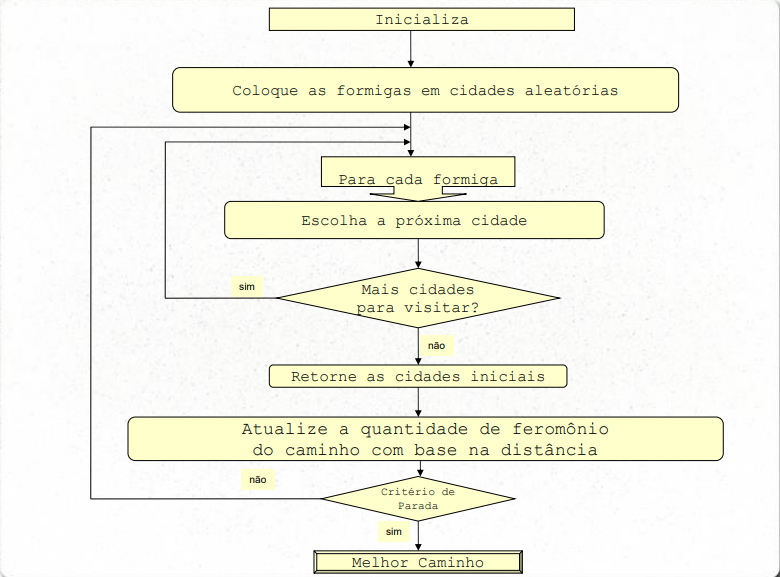

A probabilidade de transição é de uma formiga de $i$ para $j$ é dada por 

$$
p_{ij}^k = \frac{ (\tau_{ij})^\alpha (\eta_{ij})^\beta }{\sum_{I \in \mathcal{N}_i^k  \tau_{ij})^\alpha (\eta_{ij})^\beta } }
$$

Em que 
- $\eta_{ij}$ diz respeito ao inverso do custo da aresta $ij$, de modo que quanto maior for o caminho, menor sera o valor e portanto, menor será a probabilidade de uma formiga usar essa aresta.

- $\tau_{ij}$ representa a quantidade de feromônios presente na aresta $ij$ e é dado por 

$$
\tau_{ij} = (1- \rho) \tau_{ij} + \sum_{k=1}^{m} \Delta \tau_{ij}^{(k)}
$$

- $\rho$ diz respeito ao coeficiente de evaporação e $\Delta \tau_{ij}^{(k)} =  Q/L_k$ é a quantidade de feromônio deixada pela formiga $k$, dado por

$$
\Delta \tau_{ij}^{(k)} =  Q/L_k
$$

Sendo $Q$ uma constante qualquer e $L_k$ o custo do caminho $k$.

In [7]:
def ant_colony(cost_matrix, num_geracoes, max_ger_iguais = 300, coef_evaporacao = 0.1 ,alfa = 1 , beta = 1, printar_geracoes = False):
    """
    Faz o processo de criacao de novas geracoes de formigas ate a convergencia 
    """

    matriz_fero = np.ones_like(cost_matrix).astype(float)
    tam_pop = len(cost_matrix)
    population = gerar_pop_inicial(num_cidades= tam_pop, tam_pop= tam_pop)
    
    # calcular a quantidade de feromonios deixada em cada aresta (?)
    custo_caminhos = evaluate_fitness(population, cost_matrix)
    
    matriz_fero = atualizar_fero(matriz_fero, population, custo_caminhos, coef_evaporacao)
    melhor_caminho = min(custo_caminhos, key=lambda x: x[0])
    melhor_custo = melhor_caminho[0]
    menor_caminho = melhor_caminho[1]
    menor = melhor_custo
    melhores_caminhos = [melhor_custo]
    count = 0
    i = 0
    while i < num_geracoes and count < max_ger_iguais:
       # calcular as novas probabilidades de transicao  
        i += 1
        if printar_geracoes:
            print(f"O melhor caminho na encontrando ate a geração {i+1} custa {menor}")
        
        prob_trans = atualizar_prob_transicao(cost_matrix, matriz_fero, alfa, beta)     
       # gerar a nova populacao baseada nas novas probabilidades de transicao 
        new_population = gerar_nova_populacao(num_cidades= tam_pop, prob_trans= prob_trans) 

        population = new_population
        custo_caminhos = evaluate_fitness(population, cost_matrix)
        melhor_caminho = min(custo_caminhos, key=lambda x: x[0])
        melhor_custo = melhor_caminho[0]

        if melhor_custo < menor:
            menor = melhor_custo
            menor_caminho = melhor_caminho[1]
            count = 0
        else: 
            count +=1
        melhores_caminhos.append(menor)
        # atualizar a matriz de feromonios 
        matriz_fero = atualizar_fero(matriz_fero, population, custo_caminhos, coef_evaporacao)
    print(f"Apos {i+1} geracoes, a melhor solucao encontrada custa {melhores_caminhos[-1]} e o caminho eh")
    menor_caminho = [int(x) for x in menor_caminho]
    print(menor_caminho)
    return melhores_caminhos

def atualizar_fero(matriz_fero, pop_atual, custo_caminhos, coef_evaporacao):      
    """
    Atualiza a matriz de feromonios, baseando-se nas formulas que foram descritas acima
    """
    # meio que precisa ter um tracking de quant foi depositado em cada aresta para poder usar o coeficiente de evaporacao corretamente depois 
    matriz_depositos = np.zeros_like(matriz_fero).astype(float)
    for index_1,formiga in enumerate(pop_atual):

        for index_2 in range(len(formiga) - 1):
            v1 = formiga[index_2]
            v2 = formiga[index_2+1]
            custo_caminho = custo_caminhos[index_1][0]
            matriz_depositos[v1][v2] += 1/custo_caminho
           
    # depois de calcular todos os depositos deixados 
    
    num_cidades = len(matriz_fero)
    for v1 in range(num_cidades):
        for v2 in range(num_cidades):
            matriz_fero[v1][v2] = ((matriz_fero[v1][v2]) * (1 - coef_evaporacao)) + matriz_depositos[v1][v2]
         
    return matriz_fero

def atualizar_prob_transicao(cost_matrix, matriz_fero, alfa, beta):
    """
    Cria uma matriz com a probabilidade com as contas 
    """
    # calcular a prob de transicao de um no para outro 
    
    num_cidades = len(cost_matrix)
    matriz_probs = np.zeros_like(matriz_fero)

    for v1 in range(num_cidades):
        total_transicao = 0
        for v2 in range(num_cidades):
            if v1 != v2:
                trans_v1_v2 = ((matriz_fero[v1][v2]) ** alfa) * ((30 / cost_matrix[v1][v2]) ** beta)
                matriz_probs[v1][v2] = trans_v1_v2
                total_transicao += trans_v1_v2
        
        matriz_probs[v1] = matriz_probs[v1] / total_transicao
    

    return matriz_probs

def gerar_nova_populacao(num_cidades, prob_trans):
    """
    Gera uma nova populacao, em que cada formiga é colocada em uma cidade e seus movimentos posteriores sao definifidos baseados na matriz de probabilidade 
    """
    new_pop = []
    for formiga in range(num_cidades):
        # cada formiga começa em uma cidade única
        cidade_atual = formiga  
        solucao = [cidade_atual]
        
        while len(solucao) < num_cidades:
            prob = prob_trans[cidade_atual]
            prob = np.array([p if i not in solucao else 0 for i, p in enumerate(prob)])  
            prob /= prob.sum()  
            prox_cidade = np.random.choice(range(num_cidades), p=prob)
            solucao.append(prox_cidade)
            cidade_atual = prox_cidade

        new_pop.append(solucao)
    return new_pop
    

## Execuções

In [8]:
cost_matrix = [
    [0, 10, 15, 45, 5, 45, 50, 44, 30, 100, 67, 33, 90, 17, 50],
    [15, 0, 100, 30, 20, 25, 80, 45, 41, 5, 45, 10, 90, 10, 35],
    [40, 80, 0, 90, 70, 33, 100, 70, 30, 23, 80, 60, 47, 33, 25],
    [100, 8, 5, 0, 5, 40, 21, 20, 35, 14, 55, 35, 21, 5, 40],
    [17, 10, 33, 45, 0, 14, 50, 27, 33, 60, 17, 10, 20, 13, 71],
    [15, 70, 90, 20, 11, 0, 15, 35, 30, 15, 18, 35, 15, 90, 23],
    [25, 19, 18, 30, 100, 55, 0, 70, 55, 41, 55, 100, 18, 14, 18],
    [40, 15, 60, 45, 70, 33, 25, 0, 27, 60, 80, 35, 30, 41, 35],
    [21, 34, 17, 10, 11, 40, 8, 32, 0, 47, 76, 40, 21, 90, 21],
    [35, 100, 5, 18, 43, 25, 14, 30, 39, 0, 17, 35, 15, 13, 40],
    [38, 20, 23, 30, 5, 55, 50, 33, 70, 14, 0, 60, 30, 35, 21],
    [15, 14, 45, 21, 100, 10, 8, 20, 35, 43, 8, 0, 15, 100, 23],
    [80, 10, 5, 20, 35, 8, 90, 5, 44, 10, 80, 14, 0, 25, 80],
    [33, 90, 40, 18, 70, 45, 25, 23, 90, 44, 43, 70, 5, 0, 25],
    [25, 70, 45, 50, 5, 45, 20, 100, 25, 50, 35, 10, 90, 5, 0]
]

### Alg genético

Apos 491 geracoes, a melhor solucao encontrada custa 179 e o caminho eh
[7, 8, 3, 2, 9, 6, 14, 11, 10, 4, 5, 0, 1, 13, 12]
Apos 585 geracoes, a melhor solucao encontrada custa 186 e o caminho eh
[12, 7, 1, 9, 2, 5, 6, 14, 11, 10, 4, 0, 8, 3, 13]
Apos 360 geracoes, a melhor solucao encontrada custa 172 e o caminho eh
[4, 5, 0, 1, 9, 6, 13, 12, 7, 8, 3, 2, 14, 11, 10]
Apos 624 geracoes, a melhor solucao encontrada custa 182 e o caminho eh
[5, 0, 2, 9, 6, 14, 13, 12, 7, 8, 3, 1, 11, 10, 4]
Apos 634 geracoes, a melhor solucao encontrada custa 183 e o caminho eh
[5, 10, 9, 2, 14, 11, 6, 13, 12, 7, 8, 3, 1, 0, 4]
Apos 454 geracoes, a melhor solucao encontrada custa 202 e o caminho eh
[0, 13, 12, 7, 5, 10, 4, 1, 9, 3, 2, 8, 6, 14, 11]
Apos 837 geracoes, a melhor solucao encontrada custa 182 e o caminho eh
[9, 10, 4, 5, 6, 13, 12, 7, 8, 3, 2, 14, 11, 0, 1]
Apos 700 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[14, 11, 10, 4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6]
Apos 407 geracoe

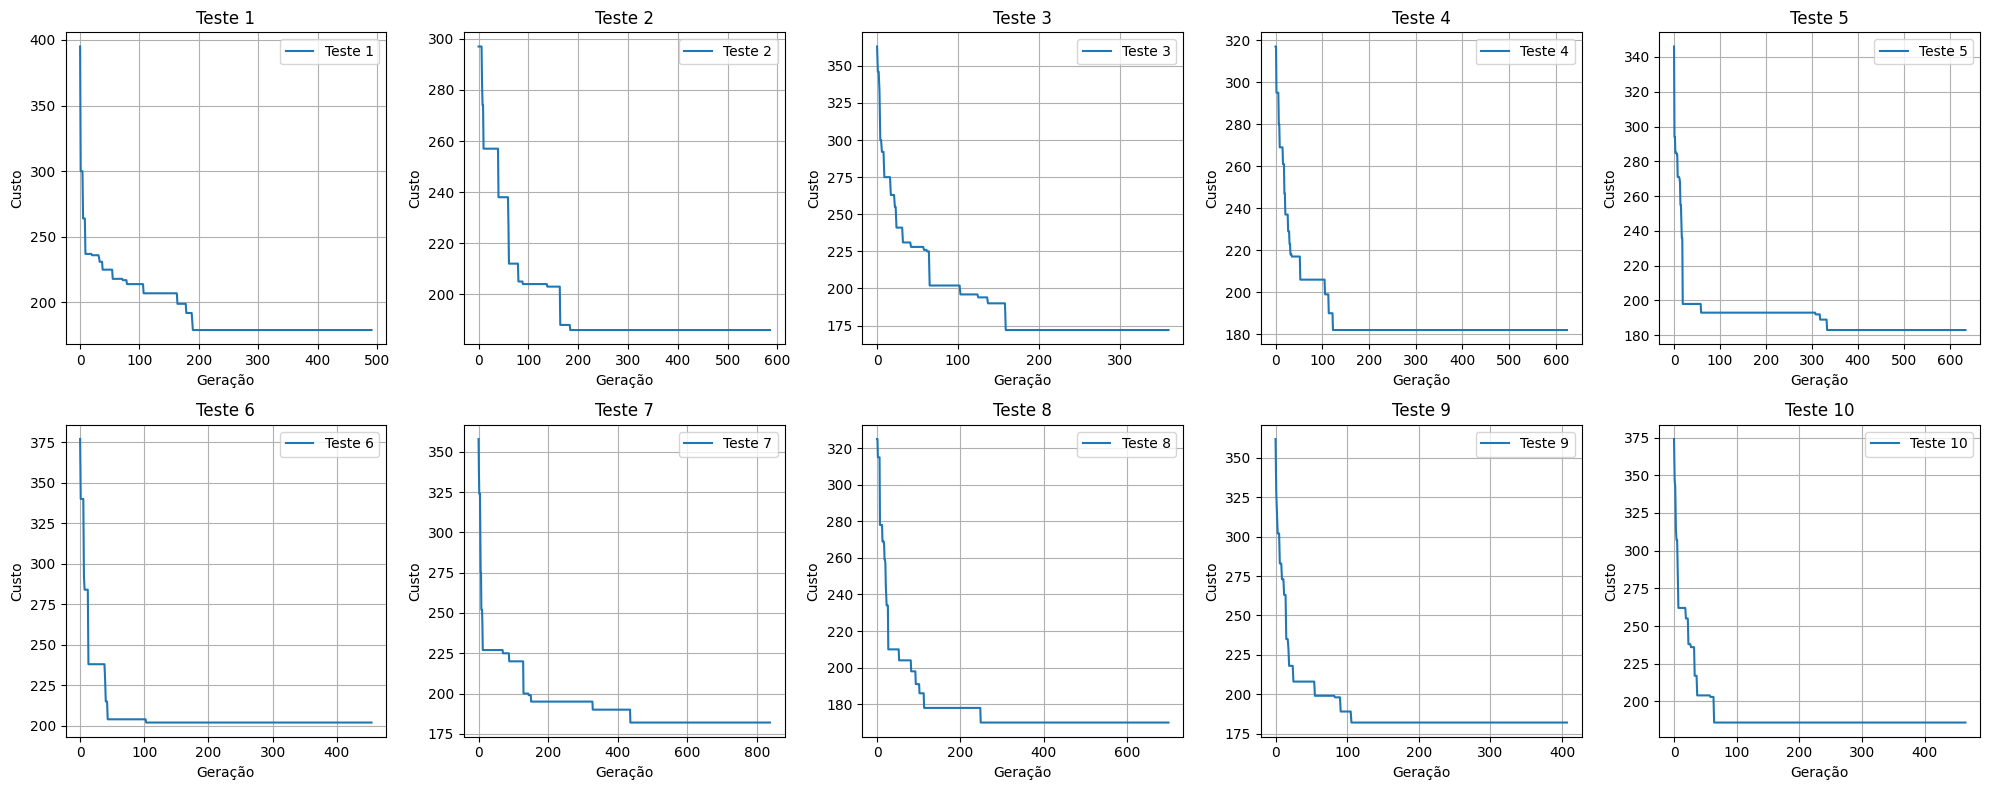

In [17]:
# 10 combinações de hiperparâmetros
testes_genetico = [
    {"num_geracoes": 1000, "tam_pop": 50, "max_ger_iguais": 300, "taxa_mutacao": 0.2},
    {"num_geracoes": 800, "tam_pop": 100, "max_ger_iguais": 400, "taxa_mutacao": 0.3},
    {"num_geracoes": 1000, "tam_pop": 150, "max_ger_iguais": 200, "taxa_mutacao": 0.1},
    {"num_geracoes": 1200, "tam_pop": 75, "max_ger_iguais": 500, "taxa_mutacao": 0.4},
    {"num_geracoes": 900, "tam_pop": 125, "max_ger_iguais": 300, "taxa_mutacao": 0.35},
    {"num_geracoes": 1100, "tam_pop": 60, "max_ger_iguais": 350, "taxa_mutacao": 0.15},
    {"num_geracoes": 1000, "tam_pop": 90, "max_ger_iguais": 400, "taxa_mutacao": 0.25},
    {"num_geracoes": 950, "tam_pop": 120, "max_ger_iguais": 450, "taxa_mutacao": 0.3},
    {"num_geracoes": 1000, "tam_pop": 100, "max_ger_iguais": 300, "taxa_mutacao": 0.2},
    {"num_geracoes": 1050, "tam_pop": 110, "max_ger_iguais": 400, "taxa_mutacao": 0.3},
]

# Executar os testes e gerar gráficos
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Grid de 2 linhas por 5 colunas

for i, params in enumerate(testes_genetico):
    # Executa o algoritmo
    curva = algoritmo_genetico(
        matriz=cost_matrix,
        num_geracoes=params["num_geracoes"],
        tam_pop=params["tam_pop"],
        max_ger_iguais=params["max_ger_iguais"],
        taxa_mutacao=params["taxa_mutacao"],
    )
    
    # Seleciona o eixo correspondente
    ax = axes[i // 5, i % 5]
    
    # Plota a curva no eixo atual
    ax.plot(curva, label=f"Teste {i + 1}")
    ax.set_title(f"Teste {i + 1}")
    ax.set_xlabel("Geração")
    ax.set_ylabel("Custo")
    ax.legend()
    ax.grid()

# Ajustar espaçamento entre os gráficos
plt.tight_layout()
plt.show()

### Colônia de Formigas

Apos 363 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[10, 4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6, 14, 11]
Apos 479 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6, 14, 11, 10]
Apos 240 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[11, 10, 4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6, 14]
Apos 325 geracoes, a melhor solucao encontrada custa 181 e o caminho eh
[11, 10, 4, 0, 1, 9, 2, 5, 3, 13, 12, 7, 8, 6, 14]
Apos 375 geracoes, a melhor solucao encontrada custa 177 e o caminho eh
[11, 6, 14, 13, 12, 7, 8, 3, 2, 9, 10, 4, 5, 0, 1]
Apos 682 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[11, 10, 4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6, 14]
Apos 706 geracoes, a melhor solucao encontrada custa 177 e o caminho eh
[2, 9, 10, 4, 5, 0, 1, 11, 6, 14, 13, 12, 7, 8, 3]
Apos 411 geracoes, a melhor solucao encontrada custa 170 e o caminho eh
[11, 10, 4, 5, 0, 1, 9, 2, 8, 3, 13, 12, 7, 6, 14]
Apos 503 geracoe

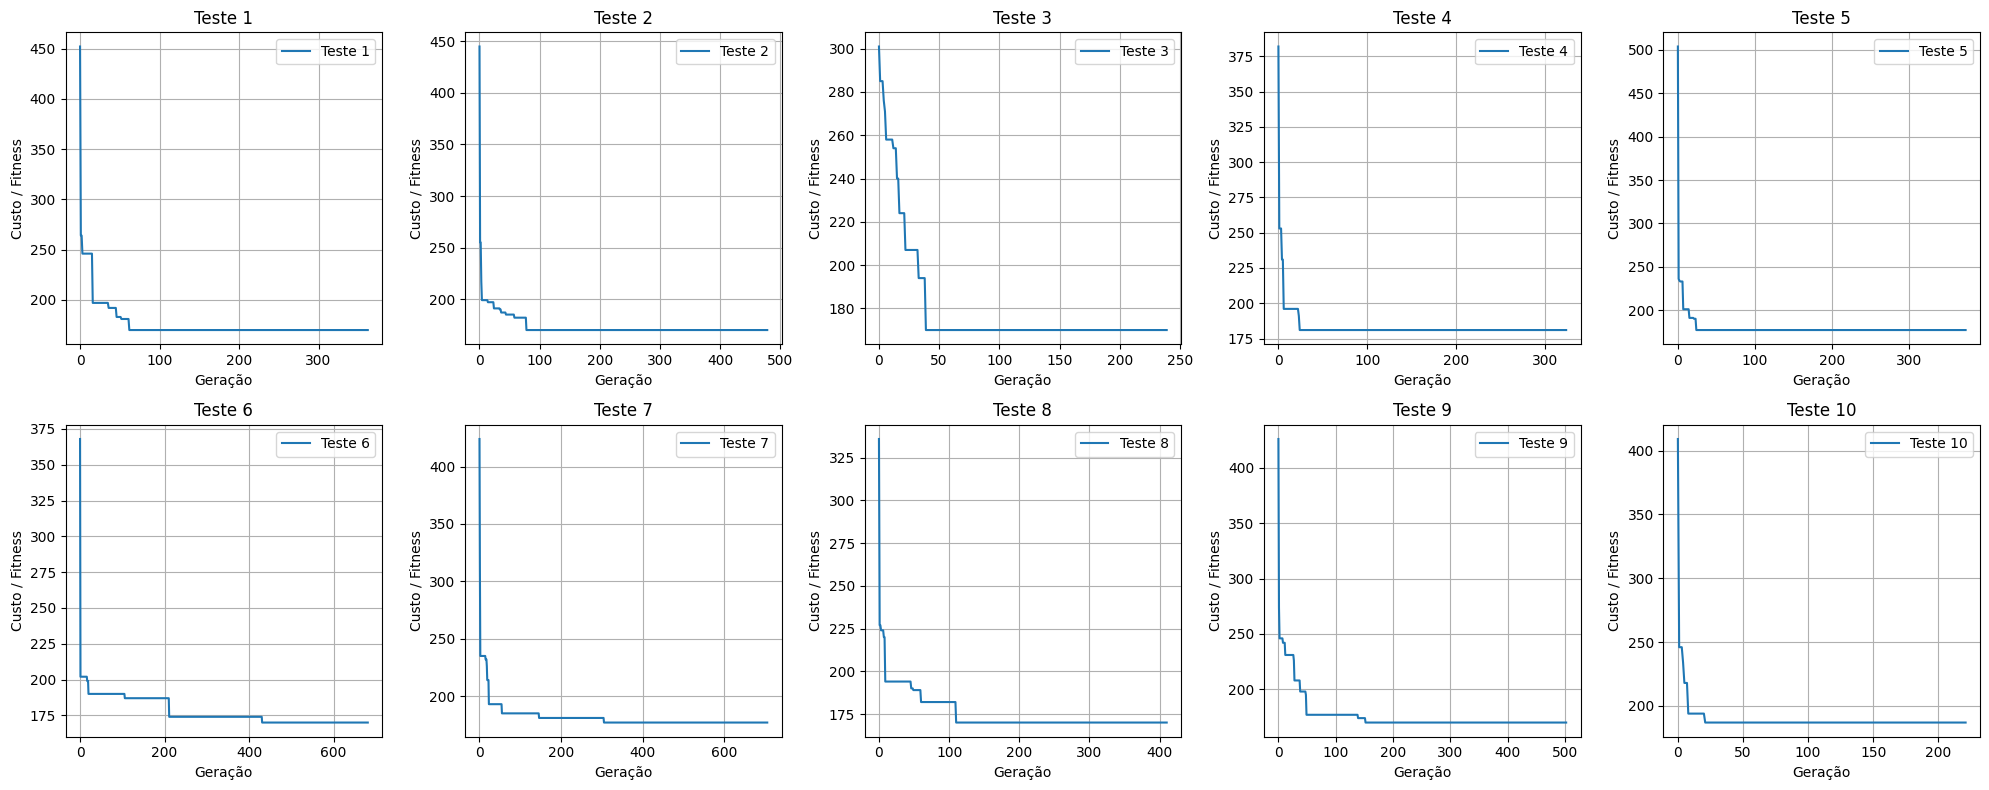

In [16]:
# 10 combinações de hiperparâmetros
testes_ant_colony = [
    {"num_geracoes": 1000, "max_ger_iguais": 300, "coef_evaporacao": 0.1, "alfa": 1, "beta": 1},
    {"num_geracoes": 1200, "max_ger_iguais": 400, "coef_evaporacao": 0.2, "alfa": 1, "beta": 2},
    {"num_geracoes": 800, "max_ger_iguais": 200, "coef_evaporacao": 0.1, "alfa": 2, "beta": 1},
    {"num_geracoes": 950, "max_ger_iguais": 300, "coef_evaporacao": 0.15, "alfa": 1.5, "beta": 1.5},
    {"num_geracoes": 1000, "max_ger_iguais": 350, "coef_evaporacao": 0.1, "alfa": 2, "beta": 2},
    {"num_geracoes": 1100, "max_ger_iguais": 250, "coef_evaporacao": 0.2, "alfa": 1, "beta": 3},
    {"num_geracoes": 1000, "max_ger_iguais": 400, "coef_evaporacao": 0.3, "alfa": 0.5, "beta": 1},
    {"num_geracoes": 1050, "max_ger_iguais": 300, "coef_evaporacao": 0.1, "alfa": 1.2, "beta": 1.8},
    {"num_geracoes": 950, "max_ger_iguais": 350, "coef_evaporacao": 0.1, "alfa": 1, "beta": 1},
    {"num_geracoes": 900, "max_ger_iguais": 200, "coef_evaporacao": 0.15, "alfa": 1.5, "beta": 2},
]

# Executar os testes e gerar gráficos
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Grid de 2 linhas por 5 colunas

for i, params in enumerate(testes_ant_colony):
    # Executa o algoritmo
    curva = ant_colony(
        cost_matrix=cost_matrix,
        num_geracoes=params["num_geracoes"],
        max_ger_iguais=params["max_ger_iguais"],
        coef_evaporacao=params["coef_evaporacao"],
        alfa=params["alfa"],
        beta=params["beta"],
    )
    
    # Seleciona o eixo correspondente
    ax = axes[i // 5, i % 5]
    
    # Plota a curva no eixo atual
    ax.plot(curva, label=f"Teste {i + 1}")
    ax.set_title(f"Teste {i + 1}")
    ax.set_xlabel("Geração")
    ax.set_ylabel("Custo / Fitness")
    ax.legend()
    ax.grid()

# Ajustar espaçamento entre os gráficos
plt.tight_layout()
plt.show()

## Análise dos resultados 

- Em geral, os algoritmos de colônia de formiga conseguiram atingir mais vezes o caminho de menor custo, 170, Mostrando ser mais estável em relação às mudanças de parâmetros do algoritmo.

- Além disso, a convergência do algoritmo se mostrou mais rápida que o genético, conseguindo chegar à solução ótima em menos de 40 gerações em um dos casos.


